In [3]:
### Pull all libraries

import numpy as np
from keras import layers
from keras import applications
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras import metrics
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger, EarlyStopping
#from keras.applications.imagenet_utils import preprocess_input
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.applications import imagenet_utils
from keras.applications import resnet50, vgg16, vgg19, densenet, inception_v3, mobilenet, mobilenetv2, nasnet, inception_resnet_v2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras import optimizers
from random import shuffle
from glob import glob
import cv2
import tensorflow as tf
from os.path import join
shuffle_data = True 
import gc
gc.collect()
import os
proxy = 'http://proxy-chain.intel.com:911'
proxy1 = 'https://proxy-chain.intel.com:912'
os.environ['http_proxy'] = proxy 
os.environ['https_proxy'] = proxy1 

Using TensorFlow backend.


# Loading data and creating test train split

In [5]:
#Loading data

# Load pickled data
import pickle
import cv2
from random import shuffle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_orig, Y_train_orig = train['features'], train['labels']
X_test_orig, Y_test_orig = test['features'], test['labels']

X_train = np.array(X_train_orig, dtype=np.float32)
X_test = np.array(X_test_orig, dtype=np.float32)

Y_train = np.array(Y_train_orig, dtype=np.float32)
Y_test = np.array(Y_test_orig, dtype=np.float32)

Y_train = to_categorical(Y_train, num_classes=None)
Y_test = to_categorical(Y_test, num_classes=None)

#Test train Split

(X_traing, X_val, Y_traing, Y_val) = train_test_split(X_train,Y_train, test_size=0.25, random_state=42, stratify=Y_train)

print (X_traing.dtype)
print (X_traing.shape)
print (X_val.shape)
print (X_val.dtype)
print (Y_traing.dtype)
print (Y_traing.shape)
print (Y_val.shape)
print (Y_val.dtype)



float32
(29406, 32, 32, 3)
(9803, 32, 32, 3)
float32
float32
(29406, 43)
(9803, 43)
float32


# Data exploration visualization

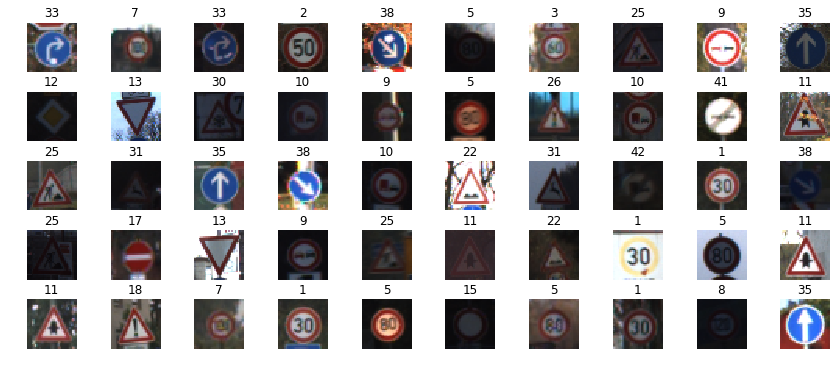

In [29]:

### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(5,10, figsize=(15, 6))
fig.subplots_adjust(hspace = .4, wspace=.004)
axs = axs.ravel()
for i in range(50):
    index = random.randint(0, len(X_train_orig))
    image = X_train_orig[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(Y_train_orig[index])

# Building a CNN model function

In [6]:
### CNN model function

def Cnnmodel(input_shape):
    
    input_shape = Input(input_shape)
    input_layer = ZeroPadding2D((8, 8))(input_shape)
    print ()
    #input_layer = input_shape
    
    
    base_model = vgg16.VGG16(input_shape=(48,48,3), include_top=False,input_tensor=input_layer,weights='imagenet',pooling=None)


    # Add a few layers at the end
    
    x = base_model.output
    x = Flatten()(x) # Flatten
    x = Dense(1024, activation="relu")(x)
    #x = Dropout(0.5)(x)
    #x = Dense(2048, activation="relu")(x)
    #x = Dropout(0.5)(x)
    #x = Dense(1024, activation="relu")(x)
    predictions = Dense(43, activation='softmax')(x) # Apply softwamx
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

# Training the model in GPU

In [ ]:
### Training CNN models
#To Categorical Classes

X_traing = vgg16.preprocess_input(X_traing)
X_val = vgg16.preprocess_input(X_val)

#Y_traing = to_categorical(Y_traing, num_classes=None)
#Y_val = to_categorical(Y_val, num_classes=None)

Cnnmodel = Cnnmodel(X_traing.shape[1:])


sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)


Cnnmodel.compile(loss='categorical_crossentropy', optimizer=sgd ,metrics=['accuracy'])


#Assigning GPU 0 for training the model

os.environ['CUDA_VISIBLE_DEVICES']='0'


filepath="Data\\vgg16_weights-improvement-{epoch:02d}-{val_acc:.2f}.h5"
checkpointer = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    
#training the model with real time augmentation of the images
with tf.device('/gpu:0'):
      
    Cnnmodel.fit(X_train, Y_train, batch_size=8, epochs=35, validation_data=(X_val, Y_val),callbacks=[checkpointer])
del datagen
del datagen_val





Train on 39209 samples, validate on 9803 samples
Epoch 1/35


# Persisting Model to Disk

In [ ]:
#Persisting Model to Disk

from keras.models import load_model
import json
import yaml


# save as JSON
json_string = model.to_json()

# save as YAML
yaml_string = model.to_yaml()

#Please change the path below to your desired directory and the name of the desired persisted model

with open('Data\\mobilenetv2_weights-improvement-39-0.99.json', 'w') as outfile:
    json.dump(json_string, outfile)
    
    
with open('Data\\mobilenetv2_weights-improvement-39-0.99.yaml', 'w') as outfile:  
    json.dump(yaml_string, outfile)

model.save_weights('Data\\mobilenetv2_weights-improvement-39-0.99_weights.h5')

# Function to Plot Confusion matrix

In [ ]:
#Plotting confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Evaluating the model of Validation dataset
import os
import pylab as pl
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, recall_score, confusion_matrix
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import itertools
from IPython.display import Image

model = load_model('Data\\mobilenetv2_weights-improvement-39-0.99.h5')
list_u = [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20, 21, 22, 23, 24, 25, 26, 27, 
           28, 29, 30,31,32,33,34,35,36,37,38,39,40,41,42]
print ('Evaluation on Validation dataset')
print ()

X_val = vgg16.preprocess_input(X_val)

'''

with tf.device('/gpu:0'):

    datagen = image.ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True, vertical_flip=True)

    datagen.fit(X_val)
''''
#preds = model.evaluate_generator(datagen.flow(X_val, Y_val, batch_size=8))

preds = model.evaluate(X_val, Y_val, batch_size=8)
print ("Loss = " + str(preds[0]))
print ("Validation Accuracy = " + str(preds[1]))


y_pred = model.predict(X_val)

#Converting back the one-hot encoded categorical vector to Integer indexes

Y_val_int = [ np.argmax(t) for t in Y_val ]
y_pred_int = [ np.argmax(t) for t in y_pred ]

#f1 , Recall

f1 = f1_score(Y_val_int, y_pred_int, average='weighted')
Re = recall_score(Y_val_int,y_pred_int, average='weighted')
print ("F1 Score = " + str(f1))
print ("Recall score = " + str(Re))

#Confusion matrix

confm = confusion_matrix(Y_val_int,y_pred_int)
print ("---Confusion matrix ---")
print ()


#Draw Confusion matrix

plt.figure(figsize=(20,16)) 
plot_confusion_matrix(confm, classes=list_u,
                      title='Confusion matrix on validation data')
plt.savefig('ConfusionMatrix1.png')



print ()

print('Evaluation on test dataset:')
print ()


#X_test = np.array(X_test, dtype=np.float64)

X_test = Vgg16.preprocess_input(X_test)

'''

with tf.device('/gpu:0'):

    datagen = image.ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True, vertical_flip=True)

    datagen.fit(X_test)
    
'''

#preds = model.evaluate_generator(datagen.flow(X_test, Y_test, batch_size=8))
preds = model.evaluate(X_test, Y_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))



y_pred_test = model.predict(X_test)

y_test_int = [ np.argmax(t) for t in Y_test ]
y_pred_test_int = [ np.argmax(t) for t in y_pred_test]

#f1 , Recall

f1 = f1_score(y_test_int, y_pred_test_int, average='weighted')
Re = recall_score(y_test_int,y_pred_test_int, average='weighted')
print ("F1 Score = " + str(f1))
print ("Recall score = " + str(Re))

#Confusion matrix

confm = confusion_matrix(y_test_int, y_pred_test_int)
print ("---Confusion matrix ---")
print ()
#print (confm)

#Draw Confusion matrix
plt.figure(figsize=(20,16)) 
plot_confusion_matrix(confm, classes=list_u,
                      title='Confusion matrix on test data')
plt.savefig('ConfusionMatrix2.png')


In [ ]:
Image(filename='ConfusionMatrix1.png')

In [ ]:
Image(filename='ConfusionMatrix2.png')